In [58]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.constants import c,hbar,k


import sys

sys.path.append('../scripts')

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from elements import *

import measurement as me

## Define optomechanical system

In [73]:
omega_c = 5e9*np.pi*2

kappa_0 = 0.3e6*np.pi*2
kappa_ex = 0.4e6*np.pi*2
kappa = kappa_0 + kappa_ex
eta_c= kappa_ex / kappa

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2



"""lambda_c=850e-9
finesse=1e4
cavity_length=250e-6
f_m=2.5e6
Q=3e7
eta_c=0.7 #fraction of losses due to transmission through output mirror, out-coupling efficiency
eta_in=0.1 #fraction of losses due to transmission through input mirror 
#(These last two parameters are inferred from Dal's coating calculations)
#t=30e-9 #membrane thickness
n_index=2 #membrane refractive index
m_eff=2e-12

#Derived quantities

omega_c=2*np.pi*c/lambda_c
omega_m=2*np.pi*f_m
omega_fsr=np.pi*c/cavity_length
kappa=omega_fsr/finesse
kappa_ex=kappa*eta_c
kappa_in=kappa*eta_in
kappa_0=kappa-kappa_ex-kappa_in
gamma_m=2*np.pi*f_m/Q"""




P_in = 1e-10

g_0 = 200*np.pi*2

omega_drive = omega_c # omega_m


from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']
Cooperativity = 4*g**2/kappa/gamma_m
print ('Cooperativity C: ',Cooperativity)

# commenting the following line out will lead to pumping on resonance
#omega_c = omdir['omega_c']

a = Mode('a', omega_c)
b = Mode('b', omega_m)

a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_drive, bath_temp=10e-3)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=10e-3)
b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)
n_th=k*10e-3/hbar/omega_m


g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [b_in0 ,a_in0, a_inex], [g_ab])
print(g)

Cooperativity C:  27518.57482674056
4360254.7294303095


## Measure Sidebands with Homodyning

<IPython.core.display.Javascript object>


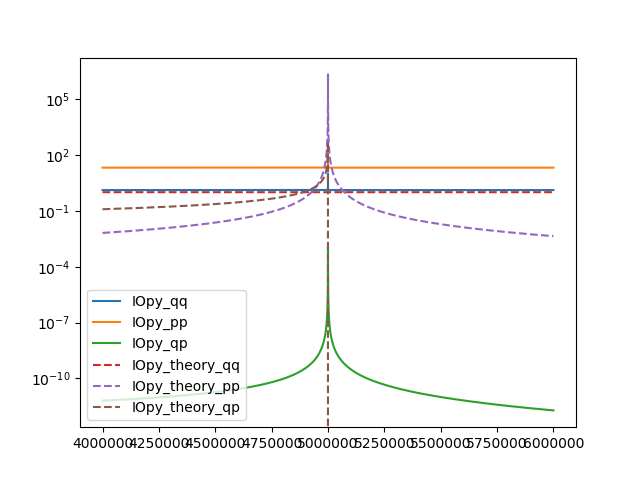

In [87]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_m - 10000*gamma_m,  omega_m + 10000*gamma_m, 10001)
t = (1) * np.pi/180

Q_qq = np.zeros((6,6))
Q_qq[:2,:2] = np.array([[1, 0],[0, 0]])
Meas_qq = me.MeasurementOperator(Q_qq, sys_om)

Q_pp = np.zeros((6,6))
Q_pp[:2,:2] = np.array([[0, 0],[0, 1]])
Meas_pp = me.MeasurementOperator(Q_pp, sys_om)

Q_qp = np.zeros((6,6))
Q_qp[:2,:2] = np.array([[0, 1/2],[1/2, 0]])
Meas_qp = me.MeasurementOperator(Q_qp, sys_om)


spec_qq = me.spectrum(omegas, Meas_qq, components= 0, plot = 0)
spec_pp = me.spectrum(omegas, Meas_pp, components= 0, plot = 0)
spec_qp = me.spectrum(omegas, Meas_qp, components= 0, plot = 0)
plt.figure()
plt.semilogy(omegas/2/np.pi, spec_qq, label = 'IOpy_qq')
plt.semilogy(omegas/2/np.pi, spec_pp, label = 'IOpy_pp')
plt.semilogy(omegas/2/np.pi, spec_qp, label = 'IOpy_qp')

#spec = me.spectrum(omegas,me.HomodynMeasurement(a_outex, t), components= 0, plot = 0)
#plt.figure()
#plt.semilogy(omegas/2/np.pi, spec*4, label = 'IOpy')



X_m = omega_m * gamma_m / (omega_m**2 - omegas**2 - 1j*omegas*gamma_m)

spec_theory_qq = 1 * np.ones_like(omegas)
spec_theory_pp = 16 * eta_c * Cooperativity * abs(X_m)**2 * (n_th+Cooperativity+0.5) *np.sin(t)**2 
spec_theory_qp = 4 * eta_c * Cooperativity * np.real(X_m) * np.sin(2*t)

plt.semilogy(omegas/2/np.pi, spec_theory_qq, label = 'IOpy_theory_qq', linestyle = 'dashed')
plt.semilogy(omegas/2/np.pi, spec_theory_pp, label = 'IOpy_theory_pp', linestyle = 'dashed')
plt.semilogy(omegas/2/np.pi, spec_theory_qp, label = 'IOpy_theory_qp', linestyle = 'dashed')



"""spec_theory = 1
spec_theory += 16 * eta_c * Cooperativity * abs(X_m)**2 * (n_th+Cooperativity+0.5) *np.sin(t)**2 
spec_theory += 4 * eta_c * Cooperativity * np.real(X_m) * np.sin(2*t)

"""


#plt.semilogy(omegas/2/np.pi, np.max(spec[:,-1]) * spec_theory / np.max(spec_theory), label = 'Theory')
#plt.semilogy(omegas/2/np.pi, spec_theory, label = 'Theory')


plt.legend()


<IPython.core.display.Javascript object>


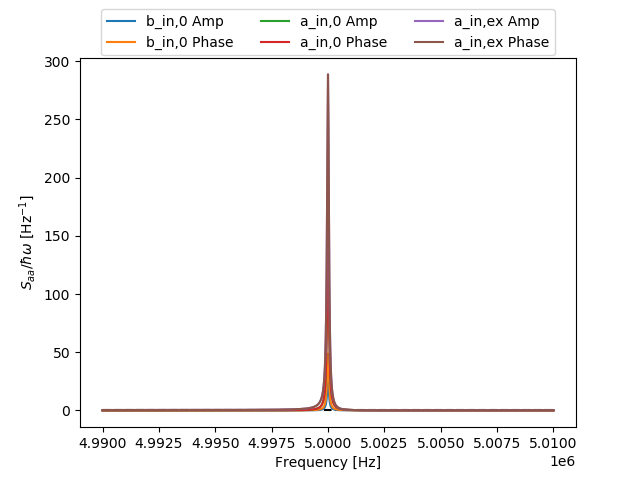

In [45]:
plt.figure()

for i, inp in enumerate(sys_om.inputs):
    plt.plot(omegas/2/np.pi, spec[:,2*i], label = str(inp) + ' Amp')
    plt.plot(omegas/2/np.pi, spec[:,2*i + 1], label = str(inp) + ' Phase')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')

plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3)

plt.hlines([0.25], min(omegas/2/np.pi), max(omegas/2/np.pi), linestyles='--')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));